## Topic Modeling

In this session, you will learn Python procedures for topic modeling and analysis from text documents.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = [
    "This shirt is very comfortable and fits perfectly",
    "Poor quality fabric tears easily not recommended",
    "Great value for money love the color and style",
    "Size runs small ordered large but fits like medium",
    "Excellent quality soft fabric feels amazing on skin",
    "Fast delivery good packaging but color faded after wash",
    "Beautiful dress perfect for special occasions highly recommend",
    "Cheap material looks nothing like the picture disappointed",
    "Comfortable shoes great for walking all day long",
    "Poor customer service return policy is terrible"
]

# Different n-gram ranges
vectorizer_1_1 = TfidfVectorizer(ngram_range=(1, 1))  # Only unigrams
vectorizer_1_2 = TfidfVectorizer(ngram_range=(1, 2))  # Unigrams + bigrams
vectorizer_2_3 = TfidfVectorizer(ngram_range=(2, 3))  # Bigrams + trigrams and # Range (2,2) - Only bigrams:

# Fit and see feature names
features_1_1 = vectorizer_1_1.fit_transform(texts)
print("Unigrams only:", vectorizer_1_1.get_feature_names_out())

features_1_2 = vectorizer_1_2.fit_transform(texts)
print("Unigrams + Bigrams:", vectorizer_1_2.get_feature_names_out())

## Table of Content
   
1. [Loading Data](#cell_LoadingData)


2. [Data Cleaning](#cell_Cleaning)
    
    
3. [Latent Dirichlet Allocation](#cell_LDA)
    - [Term Document Matrix](#cell_Matrix)
    - [Term Selection](#cell_Selection)
    - [LDA Modeling](#cell_LDAModeling)
    - [Word Probabilities by Topic](#cell_WordProbabilities)
    - [Topic Probabilities by Document](#cell_TopicProbabilitiesDocument)
    - [Topic Probabilities by Document Group](#cell_TopicProbabilitiesGroup)


4. [Selecting Topic Number](#cell_Selecting)
    - [Install Gensim Library](#cell_Gensim)
    - [Data Preperation](#cell_DataPreperation)
    - [Gensim LDA Model](#cell_GensimLDA)
    - [Experiment with Topic Numbers](#cell_Experiment)   
    - [The Best Model](#cell_Experiment)

<a id = "cell_LoadingData"></a>
### 1. Loading Data

In this tutorial, we will use the "Airport" review dataset, available from [Kaggle](https://www.kaggle.com/austinpeck/skytrax-reviews-dataset-august-2nd-2015).

In [ ]:
import pandas as pd

df = pd.read_csv('AirportReview.csv',engine='python')
df.head()

airport_name           author author_country  \
0  aalborg-airport    Klaus Malling        Denmark   
1  aalborg-airport          S Kroes    Netherlands   
2  aalborg-airport       M Andersen        Denmark   
3  aalborg-airport  Paul Van Alsten         France   
4  aalborg-airport        K Fischer            NaN   

                                             content  overall_rating  \
0  A small very effective airport with few flight...             9.0   
1  This is a nice and modern airport at the momen...             9.0   
2  A very nice airy terminal - that seems modern ...             9.0   
3  AMS-AAL and quite satisfied with this regional...             5.0   
4  Very quick check-inn and security screening. N...             4.0   

   recommended  
0            1  
1            1  
2            1  
3            0  
4            0

Show a histogram of the overall rating distribution:

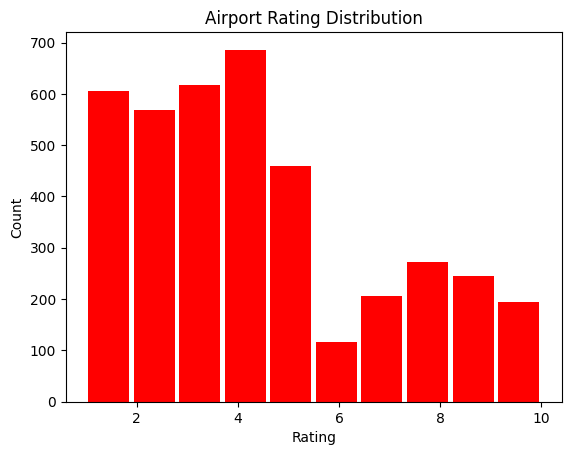

In [ ]:
from matplotlib import pyplot

pyplot.hist(df['overall_rating'].dropna(), bins=10, rwidth=0.9, color ='red')
pyplot.title('Airport Rating Distribution')
pyplot.xlabel('Rating')
pyplot.ylabel('Count')
pyplot.show()

Display boxplots of overall ratings for the authors from the 10 most popular countries in the data set.

Index(['United Kingdom', 'United States', 'Australia', 'Canada', 'India',
       'Germany', 'Netherlands', 'New Zealand', 'France', 'Thailand'],
      dtype='object', name='author_country')


/tmp/ipython-input-4-1918395265.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  pyplot.boxplot(RatingData, labels = TopCountries);


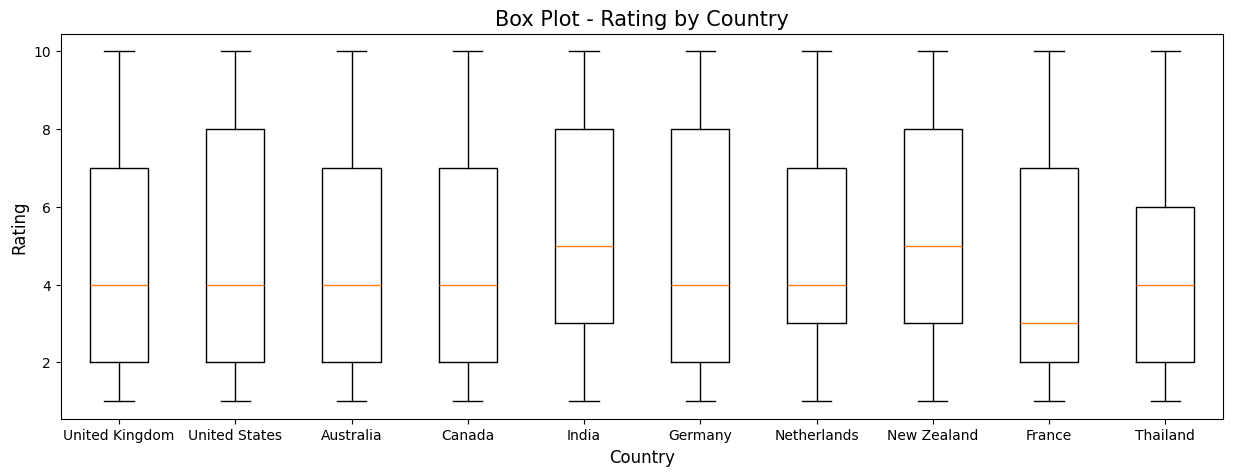

In [ ]:
AuthorCountry = df.groupby(['author_country']).count()
AuthorCountry.sort_values('airport_name', inplace=True, ascending=False)
TopCountries = AuthorCountry.index[0:10]
print(TopCountries)

RatingData = []
for i in range(len(TopCountries)):
  RatingData.append(df.loc[df['author_country'] == TopCountries[i]]['overall_rating'].dropna())

pyplot.figure(figsize=(15,5))
pyplot.title('Box Plot - Rating by Country', fontsize=15)
pyplot.xlabel('Country', fontsize=12)
pyplot.ylabel('Rating', fontsize=12)
pyplot.boxplot(RatingData, labels = TopCountries);

In [ ]:
import numpy as np
import matplotlib.pyplot as pyplot
import seaborn as sns
pd.set_option("display.max_colwidth", 200)

<a id = "cell_Cleaning"></a>
### Data Cleaning

Next, we will clean the textual data by removing the *_punctuations_*, *_numbers_*, *_special characters_*, and *_short words_*, because usually they don't contain much of the information. Finally we will make all the text lowercase to nullify case sensitivity.

In [ ]:
from nltk.stem import PorterStemmer #Stemming Package
import re  #Regular expression operation package

porter = PorterStemmer()

documents = df['content']
Cleaned_doc = []
for r in range(len(documents)):
    review = documents[r]
    try:
        # removing everything except alphabets
        review = re.sub('[^A-Za-z]', ' ', review)
        # make all text lowercase
        review = review.lower()
        # apply tokenization
        Tokens = review.split()
        # apply stemming operation (Optional)
        #for t in range(len(Tokens)):
        #    Tokens[t] = porter.stem(Tokens[t])
        # removing short words
        Filtered_token = [w for w in Tokens if len(w)>3]
        review = ' '.join(Filtered_token)
    except:
        continue
    #Save cleaned text
    Cleaned_doc.append(review)
    print('-[Review Text]: ', review)

-[Review Text]:  small very effective airport with flights check notorious quick staff friendly arrival very quick busses aalborg frequent usually problems getting taxis well there used cafeteria nowadays just kiosk good cafeteria with reasonable prizes inside terminal security check quick friendly well there nice viewing pavilion airport outside note famous kiss goodbye signs restrooms outside terminal however
-[Review Text]:  this nice modern airport moment they expanding airport there building going departure area will notice this very much airport free wifi small restaurant with shop land side airside will find small shop with packed sandwiches dogs other small stuff small duty free shop also around very cheap there lounge found moment after expansion completed there will available around check procedures fast waiting area after check fine with view tarmac nice modern small airport with expensive restaurants shop
-[Review Text]:  very nice airy terminal that seems modern enough fre

In [ ]:
#print first 5 rows
print(Cleaned_doc[0:5])


['small very effective airport with flights check notorious quick staff friendly arrival very quick busses aalborg frequent usually problems getting taxis well there used cafeteria nowadays just kiosk good cafeteria with reasonable prizes inside terminal security check quick friendly well there nice viewing pavilion airport outside note famous kiss goodbye signs restrooms outside terminal however', 'this nice modern airport moment they expanding airport there building going departure area will notice this very much airport free wifi small restaurant with shop land side airside will find small shop with packed sandwiches dogs other small stuff small duty free shop also around very cheap there lounge found moment after expansion completed there will available around check procedures fast waiting area after check fine with view tarmac nice modern small airport with expensive restaurants shop', 'very nice airy terminal that seems modern enough free wifi free parking everything within walki

Next, we need to remove the *_stop-words_* from the text data as they are mostly clutter and hardly carry any information:

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')

# Remove Stop Words
for r in range(len(Cleaned_doc)):
    each_item = []
    for t in Cleaned_doc[r].split():
        if t not in stop_words:
             each_item.append(t)
    Cleaned_doc[r] = ' '.join(each_item)
    print('-[Cleaned Text]: ', Cleaned_doc[r])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


-[Cleaned Text]:  small effective airport flights check notorious quick staff friendly arrival quick busses aalborg frequent usually problems getting taxis well used cafeteria nowadays kiosk good cafeteria reasonable prizes inside terminal security check quick friendly well nice viewing pavilion airport outside note famous kiss goodbye signs restrooms outside terminal however
-[Cleaned Text]:  nice modern airport moment expanding airport building going departure area notice much airport free wifi small restaurant shop land side airside find small shop packed sandwiches dogs small stuff small duty free shop also around cheap lounge found moment expansion completed available around check procedures fast waiting area check fine view tarmac nice modern small airport expensive restaurants shop
-[Cleaned Text]:  nice airy terminal seems modern enough free wifi free parking everything within walking distance people travel domestic copenhagen rising number international routes makes possibilit

In [ ]:
print(Cleaned_doc[0:10])

['small effective airport flights check notorious quick staff friendly arrival quick busses aalborg frequent usually problems getting taxis well used cafeteria nowadays kiosk good cafeteria reasonable prizes inside terminal security check quick friendly well nice viewing pavilion airport outside note famous kiss goodbye signs restrooms outside terminal however', 'nice modern airport moment expanding airport building going departure area notice much airport free wifi small restaurant shop land side airside find small shop packed sandwiches dogs small stuff small duty free shop also around cheap lounge found moment expansion completed available around check procedures fast waiting area check fine view tarmac nice modern small airport expensive restaurants shop', 'nice airy terminal seems modern enough free wifi free parking everything within walking distance people travel domestic copenhagen rising number international routes makes possibilities check quick security nice experience', 'qu

<a id = "cell_LDA"></a>
###  3. Latent Dirichlet Allocation

We can use probabilistic topic modeling technique such as Latent Dirichlet Allocation (LDA) to discover topics in documments. In this section, we will use LDA model available in `sklearn` library, whose full documenetation can be accessed from https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html

<a id = "cell_Matrix"></a>
###  Term Document Matrix

We can use the same preprocessed documents `Cleaned_doc`, however, it is best to use Term Frequency representation of the document instead of tf-idf representation for LDA as LDA computation is based on probability of word occurences.

### <font color="blue"> Exercise
Research the difference between Term Frequency Representation and TF-IDF representation



---

*   **Term Frequency** simply measures how often a word appears in a specific document.
*   A document is typically represented as a vector where each dimension corresponds to a unique word in the vocabulary, and the value in that dimension is the TF score of that word in the document. This is often part of a "Bag of Words" model.


---


*   **TF-IDF** is a statistical measure that reflects the significance of a term in a document relative to the entire document collection.

* It addresses the limitations of TF by down-weighting terms that appear frequently across many documents and up-weighting terms that are rare but important within a specific document. It does this by combining Term Frequency (TF) with Inverse Document Frequency (IDF).

* Similar to TF, a document is represented as a vector. However, each dimension now holds the TF-IDF score for the corresponding word.



---





In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()# Fit and transform the processed titles

count_data = count_vectorizer.fit_transform(Cleaned_doc)
count_data

<5000x12809 sparse matrix of type '<class 'numpy.int64'>'
	with 227688 stored elements in Compressed Sparse Row format>

Visualise the most common words:

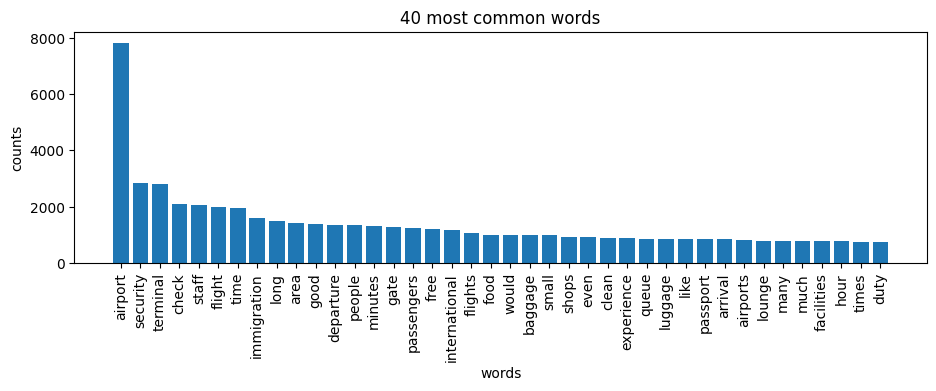

In [ ]:
import numpy as np

terms = count_vectorizer.get_feature_names_out()  #Gets the list of unique words (terms) from the count_vectorizer

# Count the popularity of words
total_counts = np.zeros(len(terms)) # Creates an array of zeros with the same length as the number of unique terms to store the total counts of each term.
for t in count_data:
    total_counts+=t.toarray()[0]   #Iterates through each document's word counts (count_data) and sums up the occurrences of each term across all documents.

count_dict = (zip(terms, total_counts)) #Creates a list of tuples, where each tuple contains a term and its total count.
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:40] #Take the top 40 words

words = [w[0] for w in count_dict]  #Extracts the words from the sorted list of tuples.
counts = [w[1] for w in count_dict] #Extracts the counts from the sorted list of tuples.
x_pos = np.arange(len(words))  #Creates an array of numbers from 0 to 39 to represent the x-axis positions for the bars in the chart.

pyplot.figure(2, figsize=(11, 3))
pyplot.subplot(title='40 most common words')
pyplot.bar(words, counts)
pyplot.xticks(x_pos, words, rotation=90)
pyplot.xlabel('words')
pyplot.ylabel('counts')
pyplot.show()

<a id = "cell_Selection"></a>
###  Term Selection

The highly frequent words such as "airport", "security" and  "terminal"  does not carry any value to help with topic discovery, as most reviews would contain these words. Such highly frequently word should be discarded. In addition, infrequrent words that appear a few times in the entire data set should be discarded as well, because they carry little value.

In [ ]:
#Remove highly frequent (Greater than 20%) and infrequent words (less than 1%)
keepIndex = [];
for t in range(len(total_counts)):
    if total_counts[t] < 1000 and total_counts[t] > 50:
        keepIndex.append(t)

print('Number of Terms Remained: ', len(keepIndex))

#Save the remain ing term and frequency data
ReducedTerm = [terms[t] for t in keepIndex]
ReducedCount = count_data[:,keepIndex]
ReducedCount

Number of Terms Remained:  906


<5000x906 sparse matrix of type '<class 'numpy.int64'>'
	with 139281 stored elements in Compressed Sparse Row format>

<a id = "cell_LDAModeling"></a>
###  LDA Modeling

Train an LDA model with 10 topics:

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Tweak the number of topics below
number_topics = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state=2023) #n_jobs=-1: Uses all available CPU cores for parallel processing, which can speed up training.
lda.fit(ReducedCount) #Fits the LDA model to discover topics
#Trained LDA model
lda.components_ #output a matrix with each row represents a topic and each column represents a term, and the values indicate the strength of association between a topic and a term.


array([[30.43092371,  0.10001617,  0.10002725, ...,  4.90084275,
         0.10001076,  0.10008289],
       [28.4351795 ,  3.61332002,  9.0786828 , ..., 97.32314948,
         4.35369306,  0.10001183],
       [21.79467757, 14.65548463,  3.74969124, ...,  3.76762043,
         4.29687669, 12.72885257],
       ...,
       [ 6.88110473,  8.58090623,  9.48960701, ..., 16.75805589,
         0.10034814,  5.51525572],
       [34.61068437,  0.10000801, 29.33465362, ...,  0.10002034,
        26.01416667,  9.10015616],
       [28.36451713, 20.92462553, 26.47966997, ..., 29.56604135,
         3.89364735,  8.34803868]])

<a id = "cell_WordProbabilities"></a>
###  Word Probabilities by Topic

`lda.components_` are parameters for topic word distribution. Since the complete conditional for topic word distribution is a Dirichlet, `components_[i, j]` can be viewed as pseudocount that represents the number of times word `j` was assigned to topic `i`. It can also be viewed as distribution over the words for each topic after normalization:

In [ ]:
#Word Probablities in Topics
Word_Topics_Pro = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
print(Word_Topics_Pro)

[[1.29142040e-03 4.24446257e-06 4.24493283e-06 ... 2.07980814e-04
  4.24423318e-06 4.24729420e-06]
 [1.84103073e-03 2.33943774e-04 5.87797733e-04 ... 6.30117032e-03
  2.81879097e-04 6.47524846e-06]
 [1.02249136e-03 6.87558066e-04 1.75915742e-04 ... 1.76756885e-04
  2.01586798e-04 5.97170648e-04]
 ...
 [4.09134288e-04 5.10200484e-04 5.64229693e-04 ... 9.96394553e-04
  5.96646418e-06 3.27924122e-04]
 [2.42767104e-03 7.01478626e-06 2.05759841e-03 ... 7.01565117e-06
  1.82469200e-03 6.38305366e-04]
 [2.04374782e-03 1.50768150e-03 1.90793897e-03 ... 2.13032121e-03
  2.80548872e-04 6.01501014e-04]]


Extract and view the top words in each topic:

In [ ]:
for topic_idx, topic in enumerate(Word_Topics_Pro):
    print("\nTopic #%d:" % topic_idx)
    count_dict = (zip(ReducedTerm, topic))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:5]
    for w in count_dict:
        print(w[0], ': {0:.3f}'.format(w[1]))


Topic #0:
clean : 0.030
shops : 0.020
easy : 0.017
nice : 0.017
friendly : 0.017

Topic #1:
customs : 0.018
domestic : 0.014
times : 0.011
wait : 0.011
many : 0.010

Topic #2:
passport : 0.036
control : 0.028
arrived : 0.021
took : 0.020
luggage : 0.018

Topic #3:
times : 0.016
like : 0.015
last : 0.013
even : 0.012
never : 0.011

Topic #4:
parking : 0.018
drop : 0.015
walk : 0.013
last : 0.011
much : 0.011

Topic #5:
city : 0.037
taxi : 0.029
train : 0.021
station : 0.018
shuttle : 0.015

Topic #6:
lounge : 0.033
small : 0.027
business : 0.024
class : 0.018
baggage : 0.015

Topic #7:
transit : 0.024
toilets : 0.013
would : 0.013
like : 0.011
queues : 0.011

Topic #8:
line : 0.016
boarding : 0.015
would : 0.014
queue : 0.013
told : 0.013

Topic #9:
duty : 0.014
prices : 0.014
lounge : 0.011
hours : 0.011
toilets : 0.011


In [ ]:
# View full Word Probabilities by Topic Matrix
df_topic_keywords = pd.DataFrame(Word_Topics_Pro)
df_topic_keywords.columns = ReducedTerm
df_topic_keywords

able  absolute  absolutely    accept    access    across  actually  \
0  0.001291  0.000004    0.000004  0.000004  0.002558  0.000005  0.000870   
1  0.001841  0.000234    0.000588  0.000006  0.000006  0.000809  0.000099   
2  0.001022  0.000688    0.000176  0.000005  0.000114  0.000140  0.000749   
3  0.000578  0.000730    0.000437  0.000445  0.000021  0.000441  0.002209   
4  0.000322  0.000364    0.001953  0.000006  0.005376  0.001655  0.000640   
5  0.000357  0.000213    0.000219  0.000057  0.000733  0.001755  0.002177   
6  0.000166  0.000007    0.000131  0.001993  0.004305  0.000961  0.000813   
7  0.000409  0.000510    0.000564  0.000075  0.001647  0.000006  0.000819   
8  0.002428  0.000007    0.002058  0.000598  0.000007  0.000514  0.001071   
9  0.002044  0.001508    0.001908  0.001523  0.001217  0.001432  0.004482   

   adelaide  adequate  afternoon  ...     world     worse     worst     worth  \
0  0.000004  0.002514   0.000004  ...  0.002165  0.000004  0.000004  0.000319   
1  0.000006  0.000006   0.000208  ...  0.004894  0.000451  0.003786  0.000650   
2  0.000005  0.000021   0.002072  ...  0.000716  0.001043  0.000848  0.000296   
3  0.000008  0.000008   0.000396  ...  0.003704  0.004418  0.006187  0.000008   
4  0.000006  0.000404   0.000364  ...  0.000667  0.002276  0.000271  0.000929   
5  0.004277  0.001109   0.000600  ...  0.000127  0.000500  0.000151  0.000637   
6  0.000007  0.001269   0.000762  ...  0.001319  0.000441  0.000459  0.001565   
7  0.000006  0.000829   0.000287  ...  0.003120  0.002501  0.004184  0.000640   
8  0.000007  0.000007   0.000007  ...  0.000011  0.000467  0.001985  0.000529   
9  0.000007  0.000287   0.000034  ...  0.003160  0.002644  0.006260  0.000007   

      would     wrong      year     years     young      zone  
0  0.001858  0.000027  0.000014  0.000208  0.000004  0.000004  
1  0.006759  0.001953  0.004287  0.006301  0.000282  0.000006  
2  0.002687  0.000005  0.000213  0.000177  0.000202  0.000597  
3  0.005117  0.000425  0.007456  0.010610  0.001453  0.000149  
4  0.007510  0.000239  0.005456  0.009073  0.000296  0.001207  
5  0.004472  0.001656  0.000009  0.001149  0.000008  0.000303  
6  0.000615  0.000732  0.000177  0.000612  0.000007  0.000007  
7  0.013116  0.000673  0.000006  0.000996  0.000006  0.000328  
8  0.013934  0.002556  0.000198  0.000007  0.001825  0.000638  
9  0.009159  0.000332  0.001563  0.002130  0.000281  0.000602  

[10 rows x 906 columns]

Visualize the word clouds for the topics generated by LDA.

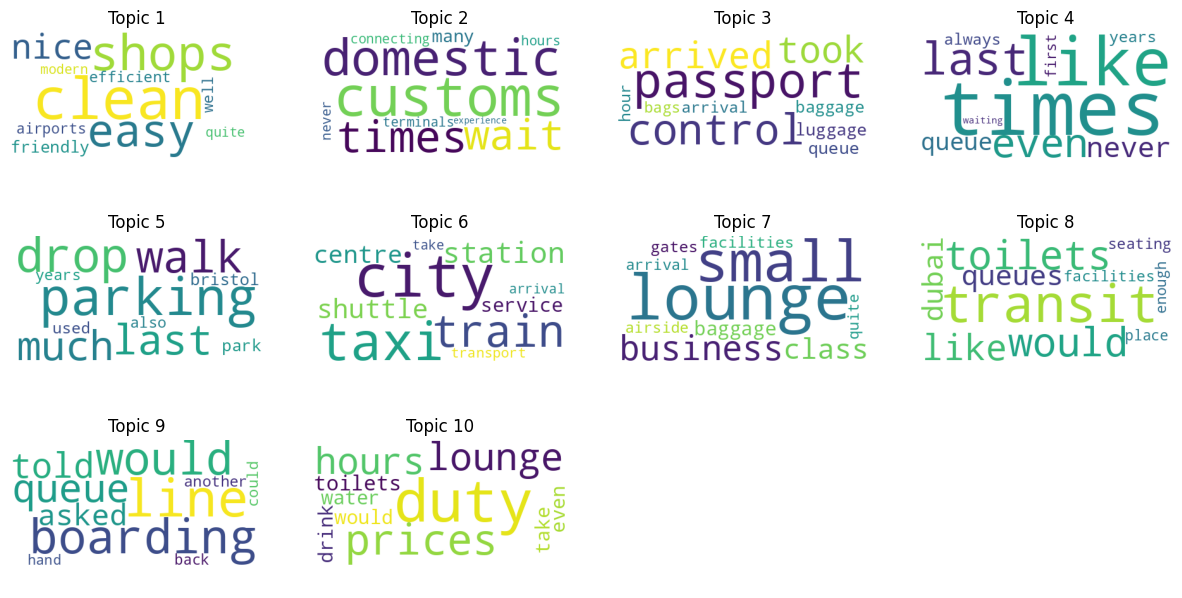

In [ ]:
#!pip install wordcloud

from wordcloud import WordCloud
import math
rows = math.ceil(len(Word_Topics_Pro)/4)
fig, ax = pyplot.subplots(rows, 4, figsize=(15,2.5*rows))
[axi.set_axis_off() for axi in ax.ravel()]
for topic_idx, topic in enumerate(Word_Topics_Pro):
    count_dict = (zip(ReducedTerm, topic))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
    # convert to dictionary type - keep top 10 words
    Word_Frequency = dict(count_dict[0:10])
    # generate word cloud
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(Word_Frequency)
    # visualize word cloud in figure
    subfig_Row = math.floor(topic_idx/4)
    subfig_Col = math.ceil(topic_idx%4)
    ax[subfig_Row,subfig_Col].imshow(wordcloud)
    ax[subfig_Row,subfig_Col].set_title("Topic {}".format(topic_idx+1))
pyplot.show()

Computer the popularity of topics over the entire data set to identify the most popular topics.

In [ ]:
#Compute topic distribution for each document
TopicDis_Doc = lda.transform(ReducedCount)

#Compute overall topic distribution for all each documents
Overall_Topic_Dis = sum(TopicDis_Doc)/sum(sum(TopicDis_Doc))
Overall_Topic_Dis

array([0.17943903, 0.09602315, 0.12120395, 0.07895196, 0.09464621,
       0.0728363 , 0.08321962, 0.11145589, 0.07731108, 0.08491281])

Visualize the topic distribution using bar chart

/tmp/ipython-input-18-3678760577.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  pyplot.legend()


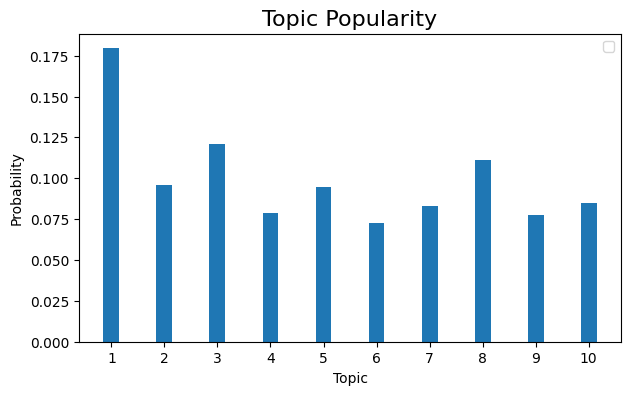

In [ ]:
# Get the topic index
Bar_index = np.asarray(range(1,number_topics+1))

#Visualize topic distributions of review groups
pyplot.figure(figsize=(7,4))
pyplot.title('Topic Popularity', fontsize=16)
pyplot.xlabel('Topic')
pyplot.ylabel('Probability')
pyplot.bar(Bar_index, Overall_Topic_Dis.tolist(), 0.3)
pyplot.xticks(Bar_index, Bar_index)
pyplot.legend()
pyplot.show();

<a id = "cell_TopicProbabilitiesDocument"></a>
###  Topic Probabilities by Document

Compute the topic distribution for individual documents:

In [ ]:
# View full Topic Probabilities by Document Matrix
TopicDis_Doc = lda.transform(ReducedCount)
df_document_topics = pd.DataFrame(TopicDis_Doc)
df_document_topics

0         1         2         3         4         5         6  \
0     0.673977  0.004001  0.004001  0.004001  0.004001  0.294017  0.004001   
1     0.242688  0.002326  0.002326  0.002326  0.002326  0.002326  0.738705   
2     0.954991  0.005001  0.005000  0.005002  0.005002  0.005001  0.005001   
3     0.234488  0.003334  0.003334  0.003334  0.003334  0.267217  0.474957   
4     0.574567  0.006668  0.006669  0.006668  0.006671  0.006668  0.006669   
...        ...       ...       ...       ...       ...       ...       ...   
4995  0.004348  0.004349  0.251519  0.004349  0.004349  0.004349  0.004349   
4996  0.175661  0.005000  0.005001  0.005001  0.005001  0.005001  0.378757   
4997  0.066682  0.002565  0.002565  0.002565  0.002565  0.002565  0.404641   
4998  0.287207  0.691164  0.002704  0.002704  0.002703  0.002704  0.002704   
4999  0.003449  0.003450  0.320907  0.003450  0.130240  0.172356  0.003449   

             7         8         9  
0     0.004000  0.004000  0.004001  
1     0.002326  0.002326  0.002326  
2     0.005001  0.005000  0.005001  
3     0.003334  0.003334  0.003334  
4     0.006668  0.372084  0.006668  
...        ...       ...       ...  
4995  0.713691  0.004348  0.004349  
4996  0.332429  0.083147  0.005002  
4997  0.510724  0.002565  0.002565  
4998  0.002704  0.002703  0.002703  
4999  0.355802  0.003449  0.003449  

[5000 rows x 10 columns]

Topic Probablity distribution by Document: 
 [[0.67397739 0.00400072 0.00400073 0.00400065 0.00400103 0.29401707
  0.00400112 0.00400033 0.00400043 0.00400054]
 [0.24268752 0.00232581 0.00232593 0.00232612 0.00232601 0.00232599
  0.7387048  0.00232596 0.00232582 0.00232603]
 [0.95499064 0.00500123 0.00500043 0.00500166 0.00500198 0.00500111
  0.00500108 0.00500085 0.00500048 0.00500055]
 [0.23448781 0.00333412 0.00333439 0.00333377 0.00333413 0.26721701
  0.47495664 0.00333414 0.00333424 0.00333374]
 [0.57456702 0.0066677  0.00666891 0.00666847 0.00667064 0.00666779
  0.00666902 0.00666803 0.37208433 0.0066681 ]]


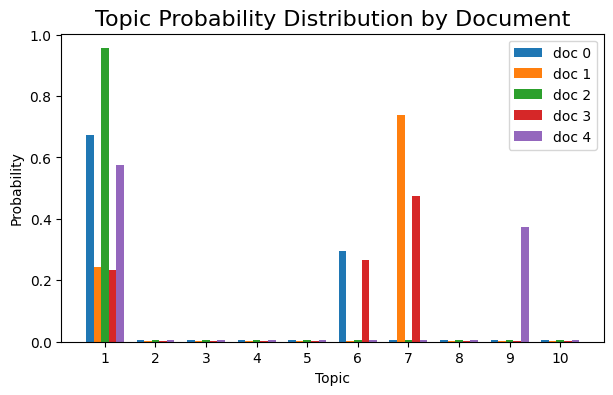

In [ ]:
# Compute the topic distribution for some reviews:
TopicDis_Doc = TopicDis_Doc[0:5]
print('Topic Probablity distribution by Document: \n', TopicDis_Doc)
# Get the topic index
Bar_index = np.asarray(range(1,number_topics+1))

#Create a new figure
pyplot.figure(figsize=(7,4))
pyplot.title('Topic Probability Distribution by Document', fontsize=16)
pyplot.xlabel('Topic')
pyplot.ylabel('Probability')

width = 0.15
for i in range(0,5):
    pyplot.bar(Bar_index + i*width, TopicDis_Doc[i].tolist(), width,  label='doc ' + str(i))

pyplot.xticks(Bar_index + 2*width, Bar_index)
pyplot.legend()
pyplot.show();
#NOTE: Different Run may result in Different Graph
#due to the Randomization when training the LDA model

<a id = "cell_TopicProbabilitiesGroup"></a>
###  Topic Probabilities by Document Group

Business managers are often interesting in idendifying topics, which are frequrently mentioned by specific groups of reviewers. We can compute the probablity distribution with respect to document groups by normalizing the probablities of topics over multiple documents in a group. For demonstration, we compute and **display the topic probability distributions of documents**, which were written by **reviewers from United Kindom**:

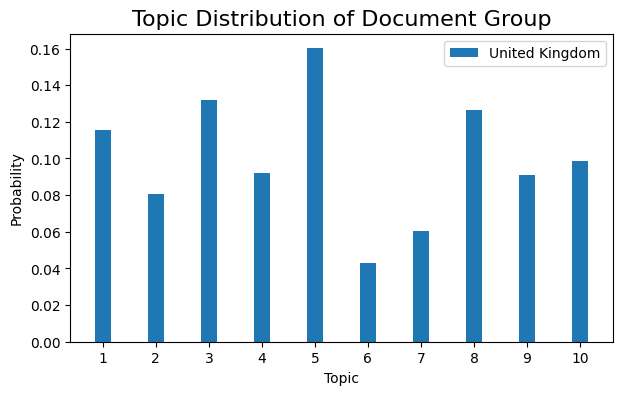

In [ ]:
import numpy as np

#Get the word count of document written by people from United Kingdom
ReducedTerm_Selected = ReducedCount[np.where(df['author_country'] == 'United Kingdom')]
#Compute topic distribution for each document
TopicDis_Doc = lda.transform(ReducedTerm_Selected)

#Compute overall topic distribution for all documents
Group_Topic_Dis = sum(TopicDis_Doc)/sum(sum(TopicDis_Doc)) #sums the topic probabilities across all selected documents and then normalizes these sums to get a probability distribution.

#Visualize topic distributions of review groups
pyplot.figure(figsize=(7,4))
pyplot.title('Topic Distribution of Document Group', fontsize=16)
pyplot.xlabel('Topic')
pyplot.ylabel('Probability')
pyplot.bar(Bar_index, Group_Topic_Dis.tolist(), 0.3,  label='United Kingdom')
pyplot.xticks(Bar_index, Bar_index)
pyplot.legend()
pyplot.show();
#NOTE: Different Run may result in Different Graph
#due to the Randomization when training the LDA model

Display topic probability distributions of reviews written by people from *_United States_* , *_Australia_*, *_India_* and *_Thailand_*.

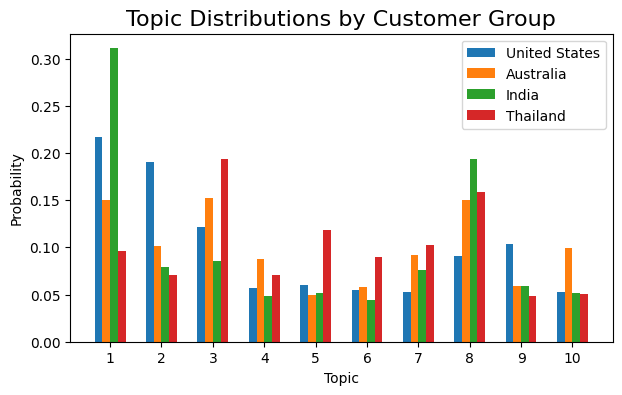

In [ ]:
import numpy as np

Selected_Countries = ['United States','Australia','India','Thailand']

Group_Prob = []
for i in range(len(Selected_Countries)):
    ReducedTerm_Selected = ReducedCount[np.where(df['author_country'] == Selected_Countries[i])]
    TopicDis_Doc = lda.transform(ReducedTerm_Selected)
    Group_Prob.append(sum(TopicDis_Doc)/sum(sum(TopicDis_Doc)))


#Create a new figure
pyplot.figure(figsize=(7,4))
pyplot.title('Topic Distributions by Customer Group', fontsize=16)
pyplot.xlabel('Topic')
pyplot.ylabel('Probability')

width = 0.15
for i in range(len(Selected_Countries)):
    pyplot.bar(Bar_index + i*width, Group_Prob[i].tolist(), width,  label=Selected_Countries[i])

pyplot.xticks(Bar_index + 1.5*width, Bar_index)
pyplot.legend()
pyplot.show();

<a id = "cell_Selecting"></a>
###  4. Selecting Topic Number

An important issue in topic modeling is to chose the best number of topics ***k***. We can evaluate the quality of topic models by masuring by ***topic coherence score***. In general, a better model would prdouce a higher score.


Although, `sklearn` library can be used to construct topic model using `LatentDirichletAllocation` module, it does not provide function to compute topic coherence. We can explore an alternative library, named **gensim**, which can be used to construct LDA models and evaluate model quality with coherence score. Full documentation about `gensim` package can be accessed from https://radimrehurek.com/gensim/models/ldamodel.html

<a id = "cell_Gensim"></a>
###  Install Gensim Library

We need to install package `gensim`, if this library is not yet available in your python environment.

In [ ]:
#This only needs to run once to install Gensim package
#Make sure that your computer is connected to the Internet
#!pip install Cython
#!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

<a id = "cell_DataPreperation"></a>
###  Data Preperation

We can use the preprocessed document `Cleaned_doc` to train LDA model with `gensim` library. However, the LDA module in this libary requires the input data to be in a special format. We need to apply several operations to prepare the input data.

First, we filter the documents in `Cleaned_doc` to keep only the terms in `ReducedTerm` that we selected previsouly in **Term Selection** section:

In [ ]:
Cleaned_doc_new = []
print('CLEANED TEXT NEW: ')
for r in range(len(Cleaned_doc)):
    each_item = []
    for t in Cleaned_doc[r].split():
        #Keep only terms included in ReducedTerm
        if t in ReducedTerm:
             each_item.append(t)
    Cleaned_doc_new.append(each_item)
    print(Cleaned_doc_new[r])

Next, construct a term dictionary following required format of LDA module in `gensim` library:

In [ ]:
import gensim.corpora as corpora

# Construct term dictionary in the format "Term : Index"
id2word = corpora.Dictionary(Cleaned_doc_new)
print(id2word.token2id)

{'arrival': 0, 'frequent': 1, 'friendly': 2, 'getting': 3, 'however': 4, 'inside': 5, 'nice': 6, 'note': 7, 'outside': 8, 'problems': 9, 'quick': 10, 'reasonable': 11, 'restrooms': 12, 'signs': 13, 'small': 14, 'taxis': 15, 'used': 16, 'usually': 17, 'well': 18, 'airside': 19, 'also': 20, 'around': 21, 'available': 22, 'building': 23, 'cheap': 24, 'duty': 25, 'expensive': 26, 'fast': 27, 'find': 28, 'fine': 29, 'found': 30, 'going': 31, 'land': 32, 'lounge': 33, 'modern': 34, 'moment': 35, 'much': 36, 'packed': 37, 'procedures': 38, 'restaurant': 39, 'restaurants': 40, 'sandwiches': 41, 'shop': 42, 'side': 43, 'tarmac': 44, 'view': 45, 'waiting': 46, 'wifi': 47, 'airy': 48, 'copenhagen': 49, 'distance': 50, 'domestic': 51, 'enough': 52, 'everything': 53, 'experience': 54, 'makes': 55, 'number': 56, 'parking': 57, 'seems': 58, 'travel': 59, 'walking': 60, 'within': 61, 'baggage': 62, 'boarding': 63, 'costs': 64, 'cramped': 65, 'downtown': 66, 'early': 67, 'efficient': 68, 'every': 69, '

Next, convert `Cleaned_doc_new` into bag of word representation based on the computed dictionary `id2word`. The presentation is in **(Term Index, Frequency)** format. For example, **(3, 5)** means that the term at index location **3** appears **5** times in the current document.

In [ ]:
#Bag of Word Representation
Corpus = [id2word.doc2bow(text) for text in Cleaned_doc_new]
print(Corpus)

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2)], [(6, 2), (14, 5), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 4), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)], [(6, 2), (10, 1), (34, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1)], [(2, 1), (6, 1), (10, 1), (19, 1), (22, 1), (59, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1)], [(6, 1), (10, 1), (46, 1), (48, 1), (57, 1), (67, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1)], [(2, 

<a id = "cell_GensimLDA"></a>
###  Gensim LDA Model

Construct LDA model using `gensim` library:

In [ ]:
import gensim
from gensim.models.ldamodel import LdaModel
from pprint import pprint#

#Train model using bag of word reprentation
lda_model = gensim.models.ldamodel.LdaModel(corpus=Corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       random_state=100)

#Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=10))
doc_lda = lda_model[Corpus]

Compute topic coherence sore:

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score. Note: that CoherenceModel require
# text input format (Cleaned_doc_new) instead of bag of word
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=Cleaned_doc_new,
                                     dictionary=id2word,
                                     coherence='c_v')


coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4397695614212086


<a id = "cell_Experiment"></a>
###  Experiment with Topic Numbers

We construct multiple LDA modles with varied numbers of topics and evaluate their coherence score.

In [ ]:
#Evaluation models with topics numbers from 2 to 10
Topics = list(range(2,11,1))
coherence_scores = []
Trained_Models = []
for top in Topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=Corpus,
                                               id2word=id2word,
                                               num_topics=top,
                                               random_state=100)
    #Keep the trained models
    Trained_Models.append(lda_model)
    #Compute coherence score for each model
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=Cleaned_doc_new,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
    #Save and print the coherence scores
    coherence_scores.append(coherence)
    print('Topic Number: {0} -- Coherence: {1}'.format(top, coherence))

Topic Number: 2 -- Coherence: 0.4282449306352882


Topic Number: 3 -- Coherence: 0.42903842580650453


Topic Number: 4 -- Coherence: 0.42991458337384564


Topic Number: 5 -- Coherence: 0.46798797522500823


Topic Number: 6 -- Coherence: 0.47405266665829343


Topic Number: 7 -- Coherence: 0.4642454023357964


Topic Number: 8 -- Coherence: 0.459705667774741


Topic Number: 9 -- Coherence: 0.4427337337424857
Topic Number: 10 -- Coherence: 0.4397695614212086


Plot the coherence scores for the ease of interpretation. The desired topic number is the one that produce highest coherence score.

Text(0, 0.5, 'Coherence')

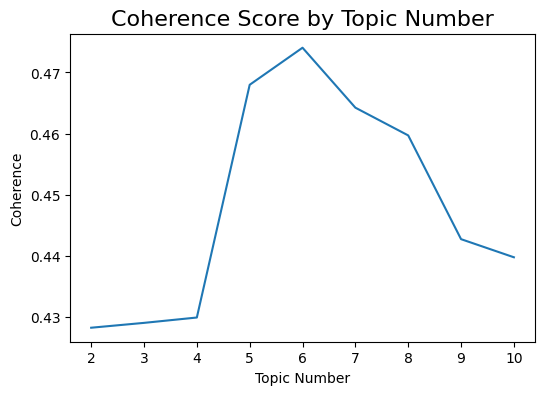

In [ ]:
pyplot.figure(figsize=(6,4))
pyplot.plot(coherence_scores)
pyplot.xticks(range(0,len(Topics)),Topics)
pyplot.title('Coherence Score by Topic Number', fontsize=16)
pyplot.xlabel('Topic Number')
pyplot.ylabel('Coherence')

<a id = "cell_Experiment"></a>
###  The Best Model

Extract and analyze the best LDA model.

In [ ]:
import numpy
lda_model = Trained_Models[numpy.argmax(coherence_scores)]

#Show top 10 words in each topic
lda_model.show_topics(num_words=10)

[(0,
  '0.011*"even" + 0.010*"like" + 0.009*"always" + 0.008*"taxi" + 0.007*"never" + 0.007*"really" + 0.007*"many" + 0.007*"customs" + 0.006*"much" + 0.006*"city"'),
 (1,
  '0.011*"airports" + 0.009*"customs" + 0.009*"take" + 0.009*"still" + 0.008*"much" + 0.008*"denver" + 0.007*"small" + 0.007*"passport" + 0.007*"better" + 0.006*"baggage"'),
 (2,
  '0.013*"would" + 0.011*"passport" + 0.010*"queue" + 0.010*"queues" + 0.009*"experience" + 0.009*"hours" + 0.008*"control" + 0.008*"arrival" + 0.007*"like" + 0.007*"toilets"'),
 (3,
  '0.012*"luggage" + 0.010*"baggage" + 0.010*"hour" + 0.009*"small" + 0.008*"took" + 0.008*"also" + 0.008*"arrived" + 0.008*"line" + 0.007*"another" + 0.007*"waiting"'),
 (4,
  '0.016*"clean" + 0.014*"lounge" + 0.010*"transit" + 0.009*"nice" + 0.009*"well" + 0.008*"shops" + 0.008*"friendly" + 0.008*"much" + 0.007*"easy" + 0.007*"gates"'),
 (5,
  '0.010*"experience" + 0.010*"transit" + 0.009*"queue" + 0.009*"queues" + 0.008*"hours" + 0.008*"boarding" + 0.008*"wai

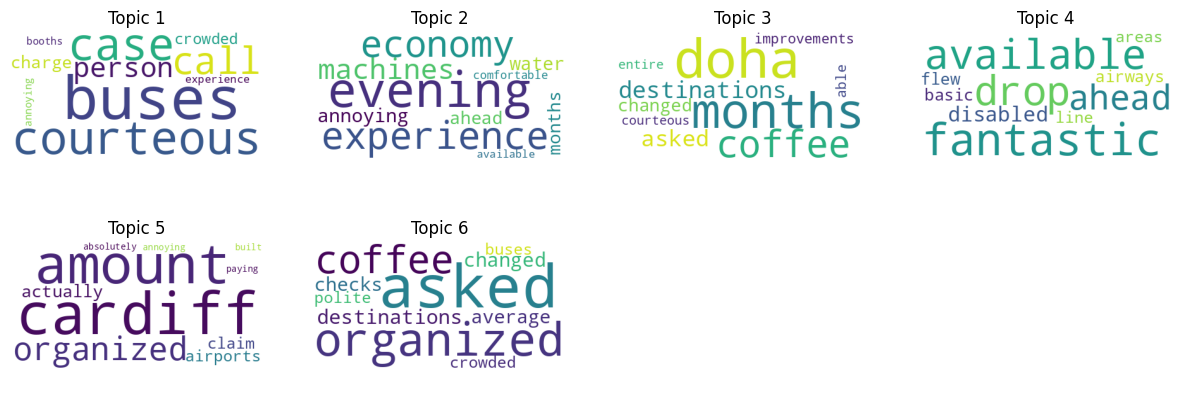

In [ ]:
# Visualize the word clouds for the topics generated by LDA.
# Just for instructors (if student queries)

rows = math.ceil(lda_model.num_topics/4)
fig, ax = pyplot.subplots(rows, 4, figsize=(15,2.5*rows))
[axi.set_axis_off() for axi in ax.ravel()]
for topic_idx, topic in enumerate(lda_model.get_topics()):
    count_dict = (zip(ReducedTerm, topic))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
    # convert to dictionary type - keep top 10 words
    Word_Frequency = dict(count_dict[0:10])
    # generate word cloud
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(Word_Frequency)
    # visualize word cloud in figure
    subfig_Row = math.floor(topic_idx/4)
    subfig_Col = topic_idx%4 # Corrected indexing for columns
    ax[subfig_Row,subfig_Col].imshow(wordcloud)
    ax[subfig_Row,subfig_Col].set_title("Topic {}".format(topic_idx+1))
pyplot.show()

### <font color="blue">Exercise:</font>  

Write script to display topic probability distributions of reviews written by people from *_Canada_* , *_Germany_*, *_France_* and *_New Zealand_* using the best LDA model trained by `gensim` library. What conclusion can you make by analyzing the topic distributions for each group?

<details><summary><font color="blue"><b>Click here for solution:</b></font></summary>
Selected_Countries = ['Canada', 'Germany', 'France', 'New Zealand']
Group_Prob = []
for i in range(len(Selected_Countries)):
    Index = df['author_country'] == Selected_Countries[i]
    Corpus_Selected = [Corpus[i] for i, x in enumerate(Index) if x]
    GroupDoc_Pro = lda_model.get_document_topics(Corpus_Selected)
    Margina_Pro = np.zeros(6) #Replace the number in bracket with the number of topics in your best model
    for doc in range(len(GroupDoc_Pro)):
        EachDoc = GroupDoc_Pro[doc]
        for top in range(len(EachDoc)):
            EachTopic = EachDoc[top]
            Margina_Pro[EachTopic[0]] = Margina_Pro[EachTopic[0]] + EachTopic[1]          
    Group_Prob.append(Margina_Pro/sum(Margina_Pro))

Bar_index = np.asarray(range(1,lda_model.num_topics+1))
pyplot.figure(figsize=(10,6))
pyplot.title('Topic Probability Distribution  by Document', fontsize=16)
pyplot.xlabel('Topic')
pyplot.ylabel('Probability')
width = 0.15   
for i in range(len(Selected_Countries)):
    pyplot.bar(Bar_index + i*width, Group_Prob[i].tolist(), width,  label=Selected_Countries[i])
    
pyplot.xticks(Bar_index + 1.5*width, Bar_index)
pyplot.legend()
pyplot.show();

In [ ]:
#Place your solution here

### References:

- Joshi, P. (2018). Text Mining 101: A Stepwise Introduction to Topic Modeling using Latent Semantic Analysis (using Python) https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
- Kapadia, S. (2015). Topic Modeling in Python: Latent Dirichlet Allocation (LDA), https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- Kapadia, S. (2019). Evaluate Topic Models: Latent Dirichlet Allocation (LDA), https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

